In [6]:

import math 
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 

from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.signal import decimate, resample_poly, resample
from scipy.interpolate import PchipInterpolator

from ahrs.filters.madgwick import Madgwick #ahrs library requires git clone, do not pip install


In [ ]:

xl1 = pd.read_csv(xl1_folder)
xl2 = pd.read_csv(xl2_folder)
xl3 = pd.read_csv(xl3_folder)

mg1 = pd.read_csv(mg1_folder)
mg2 = pd.read_csv(mg2_folder)
gy = pd.read_csv(gy_folder)

#collect first 1000 intervals
xl1_group = xl1.groupby('interval')
first_10_xl = [group[['interval','timestamp','xl1.x','xl1.y','xl1.z']] for i, (name,group) in enumerate(xl1_group) if i < 1000]
xl_dat = pd.concat(first_10_xl).values

mg1_group = mg1.groupby('interval')
first_10_mg = [group[['interval','timestamp','mg1.x','mg1.y','mg1.z']] for i, (name,group) in enumerate(mg1_group) if i < 1000]
mg_dat = pd.concat(first_10_mg).values

gy_group = gy.groupby('interval')
first_10_gy = [group[['interval','timestamp','gy.x','gy.y','gy.z']] for i, (name,group) in enumerate(gy_group) if i < 1000]
gy_dat = pd.concat(first_10_gy).values

print(gy_dat.shape, mg_dat.shape, xl_dat.shape)

NameError: name 'xl1_folder' is not defined

In [4]:
def gyr_offset_radians(gyr_dat, offset):
    """Put gy data in radians, remove measured error """
    gyr_off = gyr_dat - offset
    gyro_rad = gyr_off * ( np.pi / 180)
    
    return gyro_rad

def microtesla_to_nanotesla(value_µT):
    return value_µT * 1000

def clip_xl(xl_dat, clip):
    """
    XL sensors above certain thresholds are defective
    """
    xl_clipped = np.where(xl_dat > clip, clip, xl_dat)
    xl_clipped = np.where(xl_clipped < -1*clip, -1*clip, xl_clipped)
    return xl_clipped

def correct_data(dat):
    """ 
    Sorts sensor data by timestamp and removes duplicates
    Params: 
        dat: sensor data 
    """
    dat = np.array(dat).astype(float)
    sorted_dat = dat[dat[:,0].argsort()]

    _, unique_indices = np.unique(sorted_dat[:,0], return_index = True)
    processed_data = sorted_dat[unique_indices]
    return processed_data

def preprocess_imu(xl_raw, mag_raw, gyr_raw):
    """
    correct units, remove gyr offset
    Returns:
        data_matrix: (xl, mag, gyr)
    """
    xl_raw = clip_xl(xl_raw, 2)
    xl = xl_raw * 9.810665
    gyr_offset = np.array([.58, .42, -.3])
    gyr = gyr_offset_radians(gyr_raw, gyr_offset)
    mag = microtesla_to_nanotesla(mag_raw)
    return xl, mag, gyr

In [5]:
def R(q_w, q_x, q_y, q_z):
    """
    Direction Cosine Matrix to rotate between two frames
    """
    # rotation_matrix = np.array([
    #     [q_w**2+q_x**2-q_y**2-q_z**2, 2*(q_x*q_y-q_w*q_z), 2*(q_x*q_z+q_w*q_y)],
    #     [2*(q_x*q_y+q_w*q_z), q_w**2-q_x**2+q_y**2-q_z**2, 2*(q_y*q_z-q_w*q_x)],
    #     [2*(q_x*q_z-q_w*q_y), 2*(q_w*q_x+q_y*q_z), q_w**2-q_x**2-q_y**2+q_z**2]
    # ])
            
    rotation_matrix = np.array([
        [1.0-2.0*(q_y**2+q_z**2), 2.0*(q_x*q_y-q_w*q_z), 2.0*(q_x*q_z+q_w*q_y)],
        [2.0*(q_x*q_y+q_w*q_z), 1.0-2.0*(q_x**2+q_z**2), 2.0*(q_y*q_z-q_w*q_x)],
        [2.0*(q_x*q_z-q_w*q_y), 2.0*(q_w*q_x+q_y*q_z), 1.0-2.0*(q_x**2+q_y**2)]
        ])
    return rotation_matrix

def rotate_to_ned(q,vec):
    """
    rotates raw data by quaternion into global frame
    """
    rotation_matrix = R(*q)
    global_estimate = rotation_matrix.T @ vec  #eq. 10 
    
    return global_estimate


In [ ]:
def interpolate_points(dat_ned, timestamps, odr):
    
    X_interpolate = np.arange(odr)
    interpolated_data = []

    for ax in range(3):
        spline = PchipInterpolator(timestamps, dat_ned[:,ax])
        interolated_points = spline(X_interpolate)

        interpolated_data.append(interolated_points)
    return np.array(interpolated_data).T

def time_align(xyz, sensor_odr, interval_odr, name):
    """ 
    Upsample data 2x interval odr(fourier signal), decimate data back down(lowpass filter), interpolate to desired interval odr, select current interval points
    """
    xyz_w = []
    len_w = []
    for i, itvl in enumerate(xyz):
        xyz_w.append(itvl)
        len_w.append(len(itvl))

    xyz_w = np.vstack(xyz_w)

    #resample/decimate/interpolate for entire window 
    xyz_r = resample(xyz_w, num=(sensor_odr*len(len_w))*2, axis=0) # set upsample 2x odr
    # print('xyz_r', xyz_r.shape)

    factor = xyz_r.shape[0]//((sensor_odr*len(len_w))) #set to downsample back to sensor odr
    xyz_d = decimate(xyz_r, q=factor, axis=0)
    # print('xyz_d', xyz_d.shape)
    
    new_points = interpolate_points(xyz_d, np.arange(xyz_d.shape[0]), interval_odr*3)
    current_points = new_points[interval_odr:interval_odr*2] #assumes window size 3 here 
    
    return np.array(current_points)

In [7]:
def imu_processing(xl, mg, gy, interval_odr):
    """
    Main function, group data by intervals, build window of adjacent intervals for time alignment, this fixes errors on ends from resampling and decimating
    """

    sensor_odr = {"xl":1000, 'gy':1000, 'mg':20}
    sensor_dt = {'xl':.001, 'gy':.001, 'mg':.05}

    cols =['interval','timestamp','x', 'y', 'z']
    xl_df = pd.DataFrame(xl, columns=cols)
    mg_df = pd.DataFrame(mg, columns=cols)
    gy_df = pd.DataFrame(gy, columns=cols)

    xl_group = xl_df.groupby('interval')
    mg_group = mg_df.groupby('interval')
    gy_group = gy_df.groupby('interval')

    xl_global = []
    prev_q = [1,0,0,0]

    xl_w = [] #(3, n, 3) => window size 3, n points, xyz axis
    gy_w = []
    mg_w = []

    for (name1, xl_grp), (name2, mg_grp), (name3, gy_grp) in zip(xl_group, mg_group, gy_group):

        xl_ = correct_data(xl_grp.drop(columns=['interval']).values)
        mg_ = correct_data(mg_grp.drop(columns=['interval']).values)
        gy_ = correct_data(gy_grp.drop(columns=['interval']).values)
        xl_p, mg_p, gy_p = preprocess_imu(xl_[:,1:], mg_[:,1:], gy_[:,1:])

        xl_w.append(xl_p)
        mg_w.append(mg_p)
        gy_w.append(gy_p)

        if len(xl_w) > 3: #build window  
            xl_w.pop(0)
            mg_w.pop(0)
            gy_w.pop(0)
    
        if len(xl_w) != 3:
            continue 
            
        xl_t = time_align(xl_w, 1000, interval_odr, 'xl')
        mg_t = time_align(mg_w, 20, interval_odr, 'mg')
        gy_t = time_align(gy_w, 1000, interval_odr, 'gy')

        #Madgwick model gives quaternion vectors that rotate xl vector from sensor to ned frame
        model = Madgwick(acc=xl_t, mag=mg_t, gyr=gy_t, frequency=interval_odr, q0 = prev_q)
        prev_q = model.Q[-1]

        for q,x in zip(model.Q, xl_t):
            mag = np.linalg.norm(x)
            norm_vec = x / mag
            ned_vec = rotate_to_ned(q, norm_vec)
            ned_vec *= mag
            ned_vec[2] -= 9.810665 #in ned frame, assume z axis aligns with gravity, subtract it off
            xl_global.append(ned_vec)
        
    return xl_global


In [12]:
xl_ned = np.array(imu_processing(xl_dat, mg_dat, gy_dat, interval_odr=100))
print(np.array(xl_ned).shape)

xyz_r (6000, 3)
xyz_d (3000, 3)
xyz_r (120, 3)
xyz_d (60, 3)
xyz_r (6000, 3)
xyz_d (3000, 3)
xyz_r (6000, 3)
xyz_d (3000, 3)
xyz_r (120, 3)
xyz_d (60, 3)
xyz_r (6000, 3)
xyz_d (3000, 3)
xyz_r (6000, 3)
xyz_d (3000, 3)
xyz_r (120, 3)
xyz_d (60, 3)
xyz_r (6000, 3)
xyz_d (3000, 3)
xyz_r (6000, 3)
xyz_d (3000, 3)
xyz_r (120, 3)
xyz_d (60, 3)
xyz_r (6000, 3)
xyz_d (3000, 3)
xyz_r (6000, 3)
xyz_d (3000, 3)
xyz_r (120, 3)
xyz_d (60, 3)
xyz_r (6000, 3)
xyz_d (3000, 3)
xyz_r (6000, 3)
xyz_d (3000, 3)
xyz_r (120, 3)
xyz_d (60, 3)
xyz_r (6000, 3)
xyz_d (3000, 3)
xyz_r (6000, 3)
xyz_d (3000, 3)
xyz_r (120, 3)
xyz_d (60, 3)
xyz_r (6000, 3)
xyz_d (3000, 3)
xyz_r (6000, 3)
xyz_d (3000, 3)
xyz_r (120, 3)
xyz_d (60, 3)
xyz_r (6000, 3)
xyz_d (3000, 3)
xyz_r (6000, 3)
xyz_d (3000, 3)
xyz_r (120, 3)
xyz_d (60, 3)
xyz_r (6000, 3)
xyz_d (3000, 3)
xyz_r (6000, 3)
xyz_d (3000, 3)
xyz_r (120, 3)
xyz_d (60, 3)
xyz_r (6000, 3)
xyz_d (3000, 3)
xyz_r (6000, 3)
xyz_d (3000, 3)
xyz_r (120, 3)
xyz_d (60, 3)
xyz_r (60

In [ ]:
fig, axes = plt.subplots(3, figsize = (12,10))
axes[0].plot(xl_dat[:,2], label='x') #(interval, timestamp, x,y,z)
axes[1].plot(xl_dat[:,3], label='y')
axes[2].plot(xl_dat[:,4], label='z')

for ax in axes: 
    ax.legend()
fig.suptitle('XL1 RAW')
plt.show()

fig, axes = plt.subplots(3, figsize = (12,10))
axes[0].plot(gy_dat[:,2], label='x')#(interval, timestamp, x,y,z)
axes[1].plot(gy_dat[:,3], label='y')
axes[2].plot(gy_dat[:,4], label='z')

for ax in axes: 
    ax.legend()
fig.suptitle('GY RAW')
plt.show()

fig, axes = plt.subplots(3, figsize = (12,10))
axes[0].plot(xl_ned[:,0], label='x')
axes[1].plot(xl_ned[:,1], label='y')
axes[2].plot(xl_ned[:,2], label='z')

for ax in axes: 
    ax.legend()
fig.suptitle('XL1 NED')
plt.show()

In [ ]:
def keep_every_k_of_n(arr, k, n,):
    """
    Keeps `k` elements for every `n` elements from the array, simulate missing data 
    """
    kept = []
    i = 0
    while i < len(arr):
        kept.extend(arr[i:i+k])
        i += n
    return kept

# xl_missing = keep_every_k_of_n(xl_dat[:,:1000], 400,500)

#helper functions for experimenting with different parameters, plot rolling means  
xl_ = correct_data(xl_dat[:,1:])
xl_ = clip_xl(xl_, 2)
xl_ *= 9.8
xl_resample = resample(xl_[:,3]*9.8, num=6000)
xl_decimate = decimate(xl_resample, q=20)

#raw data
rolling_mean = pd.Series(xl_dat[:,3]).rolling(window=10).mean()
plt.plot(xl_dat[:,3], label='gt')
plt.plot(rolling_mean, label='rolling mean')
plt.legend()
plt.title('XL raw')
plt.show()

#xl resample
rolling_mean = pd.Series(xl_resample).rolling(window=10).mean()
plt.plot(xl_resample, label='pred')
plt.plot(rolling_mean, label='rolling mean')
plt.title('Resample')
plt.legend()
plt.show()

#xl decimate
rolling_mean = pd.Series(xl_decimate).rolling(window=10).mean()
plt.plot(xl_decimate)
plt.plot(rolling_mean)
plt.title('XL Decimate')
plt.legend()
plt.show()

spline = PchipInterpolator(np.arange(xl_decimate.shape[0]), xl_decimate)
interpolated_points = spline(np.arange())

rolling_mean = pd.Series(interpolated_points).rolling(window=10).mean()
plt.plot(interpolated_points[100:200])
plt.plot(rolling_mean[100:-1], label='mean')
plt.legend()
plt.show()


#resample and decimate xl_missing
#print(mean_squared_error(xl_decimate, xl_dat[:,:1000]))
#print(mean_absolute_error(xl_decimate, xl_dat[:,:1000]))

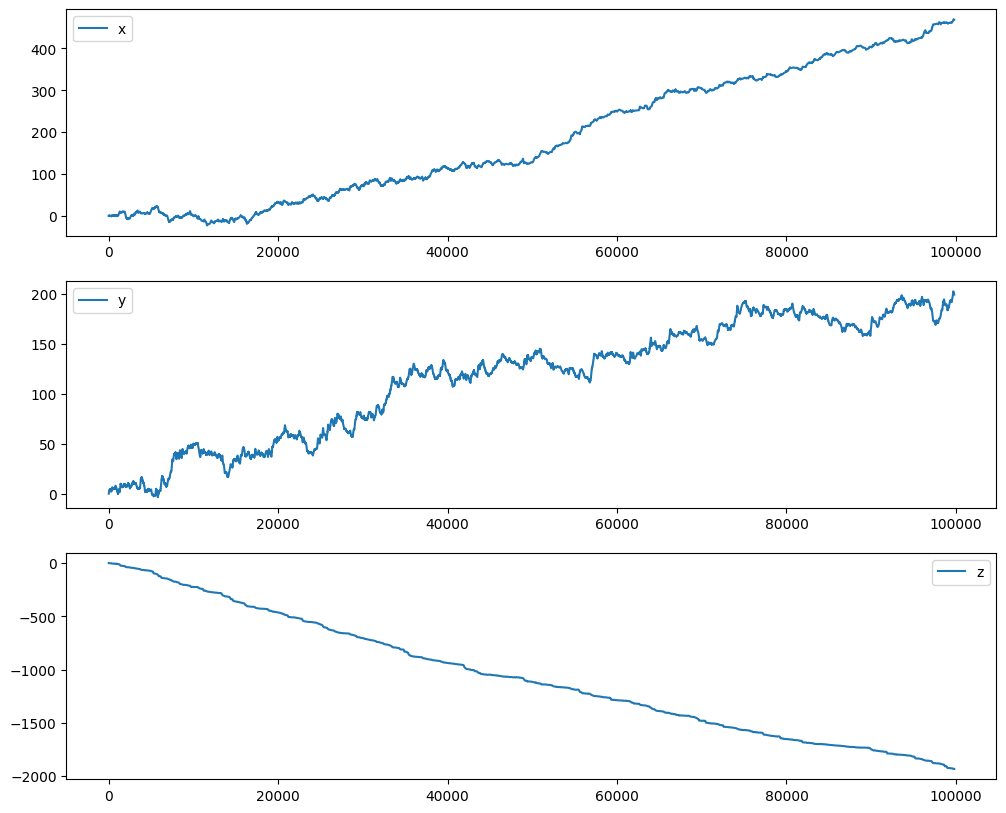

In [13]:
def imu_dead_reckoning(xl_ned, dt):
    """Calculate position, velocity and bearing from xl/mag sensors in NED frame
    Args:
        xl_ned, mag_ned: sensor data in NED frame
        dt: timestamp delta
    Retuns:
        position, velocity, bearing 
    """
    velocity = np.zeros((len(xl_ned), 3))
    position = np.zeros((len(xl_ned), 3))

    for t in range(1, len(xl_ned)):
        velocity[t] = velocity[t-1] + (xl_ned[t-1] * dt)
        position[t] = position[t-1] + (velocity[t] * dt)
    
    fig, axes = plt.subplots(3, figsize=(12,10))
    axes[0].plot(velocity[:,0], label='x')
    axes[1].plot(velocity[:,1], label='y')
    axes[2].plot(velocity[:,2], label='z')

    for ax in axes:
        ax.legend()

    plt.show()

imu_dead_reckoning(xl_ned, 1/100) #dt is set to 1/100, I downsampled to 100 points per second 